## chapter introduction by Halil Hasmer

this is by far the hardest section (and the last) of this course. I'd probably go back to this several times in the future

this chapter uses statistical arbitrage trading strategy as example

trendlines are NOT quantitative trading. They are subjective. Quant trading detects inefficencies

<b> ways to measure a strategy's performance; </b>

+ Profit and loss (Pnl Curve)
+ Comparison with benchmark (e.g, S&P500, BTCUSDT, Buy & Hold)
+ Sharpe Ratio
+ Sortino Ratio
+ Value at Risk (VaR)
+ win-loss streaks
+ avg profit per trade
+ risk-to-reward ratio

# Python for Traders and Investors -- Chapter 6

## 6.2 A simple backtest

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
# yfinance is not yahoo finance's official api but an open-source one
import yfinance as yf

In [60]:
pep = yf.download('TRIP')['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [61]:
print(type(pep))
pep

<class 'pandas.core.series.Series'>


Date
2011-12-07    24.410614
2011-12-08    23.610266
2011-12-09    24.819681
2011-12-12    24.410614
2011-12-13    24.455078
                ...    
2022-05-09    21.209999
2022-05-10    22.620001
2022-05-11    22.840000
2022-05-12    22.809999
2022-05-13    24.770000
Name: Adj Close, Length: 2626, dtype: float64

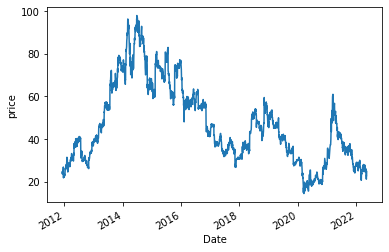

In [62]:
# Plotting the historical price data
pep.plot()
plt.ylabel('price')
plt.show()

__Buy and Hold strategy__

Buy & hold strategy step-by-step guide;

1) start buying at day 3
2) exit after holding for N days
3) wait for 2 days before trading again
4) repeat

In [63]:
# Let's define some variables

# This indicates whether we have a position on or not
inpos = 0

# Hold for 60 days
hold_period = timedelta(days=60)

wait = 0

# This is the PnL
pnl = []
pos = []
time_in_trade = []

In [64]:
for date in pep.index:
    
    if inpos == 0 and wait == 2:
        entry_price = pep[date]
        open_time = date
        inpos = 1
        
    elif inpos == 1 and date - open_time >= hold_period:
        #Profit/loss for this trade
        p = pep[date] - entry_price
        pnl.append(p)
        inpos = 0
        wait = 0
    
    elif inpos == 0 and wait < 2:
        wait += 1
        
    pos.append(inpos)

In [65]:
pnl[:3]

[6.162679672241211, 4.037311553955078, 9.355180740356445]

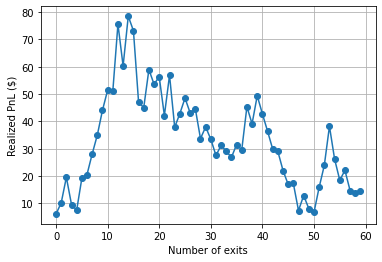

In [66]:
plt.plot(np.cumsum(pnl),'-o')
plt.xlabel('Number of exits')
plt.ylabel('Realized PnL ($)')
plt.grid()
plt.show()

## 6.3 Cointegration

 cointeagration is supposed to be used for getting entry and exit signals

 its mainly used for pairs trading

 If we take a particular linear combination of any two stocks and botain a stationary series, then we can say these 2 stocks are cointegrated.
 
 (stationary means a stock's properties such as mean, variance etc are constant over time. However, most financial time series are non-stationary)

 cointegration means the difference between two stocks are stationary and predictable


In [67]:
# Obtain the adjusted closing price
# ewc: MSCI Canada index, eaw: MSCI Australia index
price_cl = yf.download(['EWC', 'EWA'])['Adj Close']
price_cl.head()

[*********************100%***********************]  2 of 2 completed


,EWA,EWC
Date,,
1996-03-18,3.514395,4.750656
1996-03-19,3.558326,4.779448
1996-03-20,3.558326,4.779448
1996-03-21,3.602256,4.779448
1996-03-22,3.602256,4.779448


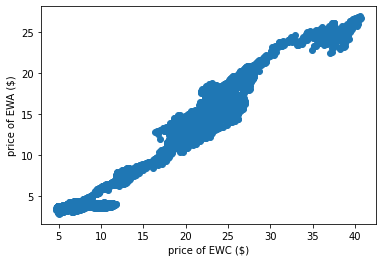

In [68]:
plt.scatter(price_cl['EWC'], price_cl['EWA'])
plt.xlabel('price of EWC ($)')
plt.ylabel('price of EWA ($)')
plt.show()

In [69]:
from statsmodels.tsa.stattools import coint

In [70]:
coint_t, pvalue, crit = coint(price_cl['EWC'], price_cl['EWA'])

coint_t < crit: reject the hypothesis that our indices are NOT contegrated with 99%, 95% or 90% certainty (respectively)

coint_t < crit[0:2] --which proves there is a high possibility of correlation

in our case crit[0] is actually lower than coint_t. which means we are not 99% certain

In [71]:
# t-statistic of unit-root test on residuals
coint_t

-3.6160199353723517

In [72]:
# p-value: how confident are we that t-statistics is correct (the closer to zero, the better)
pvalue

0.02340515141460243

In [73]:
# Critical values for the test statistic at the 1%, 5%, and 10% levels 
crit

array([-3.89810393, -3.33705804, -3.04509413])

## 6.4 Building the pairs trading strategy

** what we do in this part is called <b> Pairs Trading </b>
+ its a market neutral strategy
+ it belongs to statistical arbitrage or mean reversion strategies
+ <b>we will long one instrument and short another instrument at the same time</b> for the sake of risk hedging

trading signal: when spread > threshold
action: long the negatively diversed stock, short positively diverged stock. as they'd come together and align soon.

In [74]:
# Download the data
ewa = yf.download('EWA', start='2011-01-01', end='2019-12-23')['Adj Close']
ewc = yf.download('EWC', start='2011-01-01', end='2019-12-23')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


__Train/test split__

In [75]:
ewa_train = ewa[:-500]
ewa_test = ewa[-500:]

ewc_train = ewc[:-500]
ewc_test = ewc[-500:]

In [76]:
# here I should try what I learned in 100 days of python!

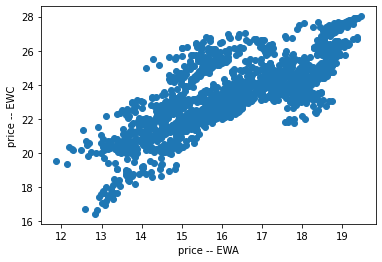

In [77]:
plt.plot(ewa_train, ewc_train,'o')
plt.xlabel('price -- EWA')
plt.ylabel('price -- EWC')
plt.show()

__Linear regression__

In [78]:
from sklearn.linear_model import LinearRegression

In [79]:
x = np.array([ewa_train]).T
y = np.array(ewc_train)

In [80]:
def LR(x, y):
    '''function for linear regression'''  
    lm = LinearRegression().fit(x, y) 
    a = lm.intercept_
    beta = lm.coef_
    
    xx = np.linspace(min(x), max(x),200) 
    yy = a + beta * xx
    return xx, yy, a, beta

In [81]:
def plot_LR(x, y):
    '''function that plots the regression with original points'''
    x_, y_, a, beta = LR(x,y)
    plt.plot(x, y,'o', ms=2)
    plt.plot(x_,y_)  # the regression line
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title('y = %f + %f*x'%(a, beta))
    return a, beta

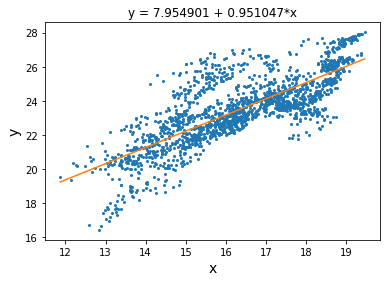

In [82]:
a, beta = plot_LR(x, y)

__Hedge ratio__

In [83]:
# The Hedge ratio would be
beta[0]

0.9510471420694283

In [84]:
# Intercept
a

7.954901082515878

__The spread__

The linear regression representation:

$$y = a + beta*x$$

$$spread = y - beta*x - a$$

In [85]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

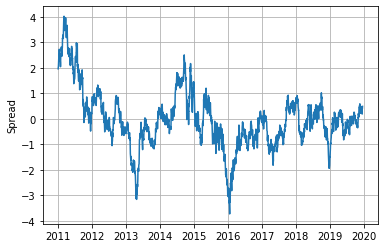

In [86]:
spread = ewc - beta[0]*ewa - a
plt.plot(spread)
plt.ylabel('Spread')
plt.grid()

In [87]:
ewc['2011-01-03']

24.660133361816406

In [88]:
print(type(spread))
spread.head()
df_spread = pd.DataFrame({'Spread': spread.values, 'EWC_Close': ewc[spread.index], 'EWA_Close': ewa[spread.index]})

<class 'pandas.core.series.Series'>


In [89]:
df_spread
# I constructed this dataframe because I did not understand why we take spread values as entering/exiting prices
# So, I'll probably use those adjusted closing values as enter and exit values and calculate PnL

,Spread,EWC_Close,EWA_Close
Date,,,
2010-12-31,1.957818,24.462852,15.299067
2011-01-03,2.069307,24.660133,15.389275
2011-01-04,2.186374,24.399723,14.992367
2011-01-05,2.330954,24.447071,14.890130
2011-01-06,2.355569,24.328703,14.739787
...,...,...,...
2019-12-16,0.184961,28.318277,21.217051
2019-12-17,0.409034,28.356661,21.021803
2019-12-18,0.390593,28.347065,21.031103


__Generating the trading signal__

Setting the threshold

spread is where the actual result don't make statistical sense. So, in the following blocks, we'd take advantage of those inefficiencies. 

We'd take action when spread got longer than 1 std, or +-0,5 std for either side

changing 0,5 affects the strategy. decreasing it couses more risk but higher num of trades and lower profit per trade. widening it couses fewer entries but higher rewards.

In [90]:
thresh = np.std(spread)*0.5

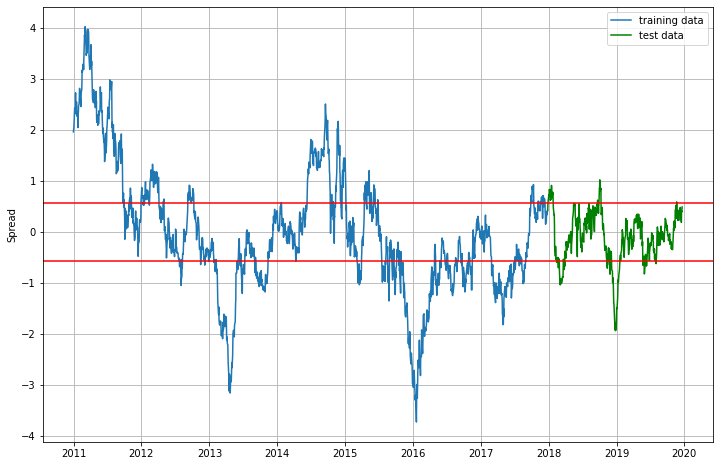

In [91]:
plt.figure(figsize=(12,8))
plt.plot(spread[:-500])
plt.plot(spread[-500:], color='g')
plt.legend(['training data', 'test data'])
plt.axhline(y = thresh, color='r')
plt.axhline(y = -thresh, color='r')
plt.ylabel('Spread')
plt.grid()
plt.show()

When the spread rises above 0.5 std, we buy EWA and sell EWC in the proportion of our hedge ratio

when the spread falls below 0.5 std, we do the opposite

## 6.5 Constructing the backtest

Let's build our first backtest around this. The rules are: 
- When our spread rises more than one standard deviation above the mean, we buy EWA and sell EWC in the proportion of our hedge ratio
- When our spread falls to more than one standard deviation below the mean, we do the opposite.

In [92]:
# The trading signal
thresh = np.std(spread)*0.5

# This indicates whether we have a position on or not
inpos = 0

# This is the PnL per trade
pnl = []

# A list to save what position we have each day
pos = []

time_in_trade = []
exit_date = []

Next, we iterate through all the dates of the spreads. We use conditional statements _if, elif_ to determine which **state** we are in. The **state** of our system is determined by whether we are long the spread, short the spread or flat. 

In order to keep our first backtest simple, we assume that our portfolio components EWA and EWC are perfectly hedged according to the equation above and we just trade in and out of one-lots of the spread.

In [93]:
# what I don't understand here is why are we getting spread values for entry and exit prices? 
# So far I thought they were our signal values, not actual price differences
# I should also factor in comissions. as far as slippage goes, I'll ignore that for now since we already use adjusted prices.
# TODO: make your own backtesting using this strategy but with adjusted and actual closing prices, in different timeframes
# TODO: apply this strategy to find cointegrated pairs in crypto
# TODO: leverage optimisation for each trade for each pair.

for date in spread.index:
    
    if spread[date] > thresh and not inpos:
        '''Entry Short Spread'''
        entry_price = spread[date]
        open_time = date
        inpos = -1
        
    elif spread[date] < 0 and inpos == -1:
        '''Exit Short Spread'''
        p =  entry_price - spread[date]
        pnl.append(p)
        inpos = 0
        time_in_trade.append((date-open_time).days)
        exit_date.append(date)
        print('Exit short:',sum(pnl))
        
    elif spread[date] < -thresh and not inpos:
        '''Entry Long Spread'''
        entry_price = spread[date]
        open_time = date
        inpos = 1
        
    elif spread[date] > 0 and inpos == 1:
        '''Exit Long Spread'''
        p = spread[date] - entry_price
        pnl.append(p)
        inpos = 0
        time_in_trade.append((date-open_time).days)
        exit_date.append(date)
        print('Exit long:',sum(pnl))  
        
    pos.append(inpos)

Exit short: 2.1040682874479213
Exit short: 2.710881785175843
Exit short: 3.370682228169132
Exit long: 4.079135230178499
Exit short: 4.924271868777595
Exit long: 5.605448616162992
Exit long: 6.373576132076263
Exit short: 7.055553919158067
Exit long: 7.671764510750878
Exit short: 8.394444159867183
Exit short: 9.352165357882006
Exit short: 9.995905501750906
Exit long: 10.831688706140875
Exit short: 11.68374159733006
Exit long: 12.636502150812735
Exit long: 13.50915807549434
Exit short: 14.393747001107958
Exit long: 14.997351139065465
Exit short: 15.672691507726935
Exit long: 16.288717391598396
Exit long: 16.973268840307373


That's it, our first relative value backtest. Let's plot the PnL curve:

In [94]:
print(time_in_trade)
print(f"total time used in backtesting: {(spread.index.max()-spread.index.min()).days} days")
print(f"total time in position: {np.sum(time_in_trade)} days")
print(f"total time idle: {(spread.index.max()-spread.index.min()).days - np.sum(time_in_trade)} days")

[277, 26, 130, 24, 47, 249, 97, 12, 18, 126, 14, 62, 35, 77, 490, 204, 128, 76, 34, 84, 77]
total time used in backtesting: 3276 days
total time in position: 2287 days
total time idle: 989 days


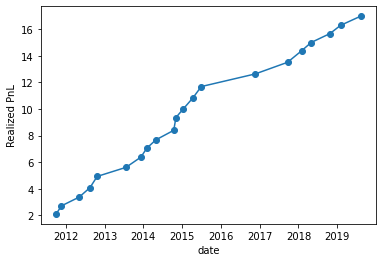

In [95]:
profit_per_trade = pd.Series(pnl)
profit_per_trade.index = exit_date

plt.plot(np.cumsum(profit_per_trade),'-o')
plt.xlabel('date')
plt.ylabel('Realized PnL')
plt.show()

## 6.6 Strategy analysis (1)

The above analysis seems really simple and obvious but actually, there is a lot more to do and understand in order to judge if this strategy is worthwhile running. There are a wide range of metrics that we can use to characterise our performance, one of them is PnL. 

Next, we calculate our daily PnL curve from the prices and positions. Note, that we use the shift(-1) function, which shifts the price changes to the left, so we end up with the correct value being multiplied to the positions. 
Small mistakes in this can dramatically change the results of your work and it is important to be really careful with implementing these metrics. We can test the validity of our calculation by plotting the daily pnl and comparing it with the values of the trade-based realised PnL calculation from above. 

In [96]:
print(type(spread))

<class 'pandas.core.series.Series'>


In [97]:
# move the 'pos' list down by 1 element, by padding
# a 0 at the start:
pos1 = [0] + pos 
daily_pnl = spread.diff()*pos1[:-1] # dont include the last value

# I have no clue what it does here with the spread.diff() and all.. TODO: evaluate it later again
# It has to do with the daily PnL. Daily spread difference makes the daily PnL.
print(spread.tail())
spread.diff().tail()

Date
2019-12-16    0.184961
2019-12-17    0.409034
2019-12-18    0.390593
2019-12-19    0.437067
2019-12-20    0.485805
Name: Adj Close, dtype: float64


Date
2019-12-16   -0.144043
2019-12-17    0.224073
2019-12-18   -0.018441
2019-12-19    0.046474
2019-12-20    0.048738
Name: Adj Close, dtype: float64

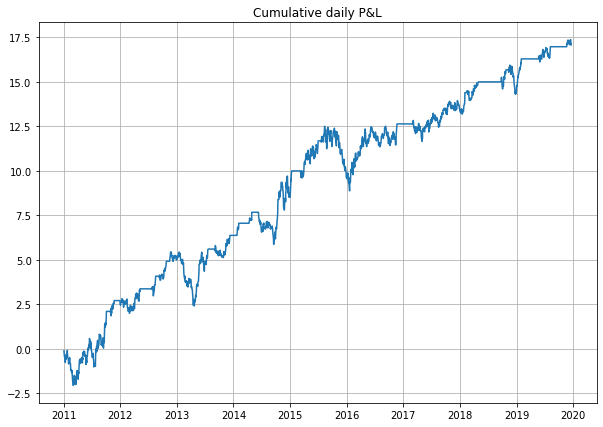

In [98]:
# Cumulative daily P&L
cum_daily_pnl = np.cumsum(daily_pnl)

plt.figure(figsize=(10,7))
plt.plot(cum_daily_pnl)
plt.title('Cumulative daily P&L')
plt.grid()
plt.show()

In [99]:
def plot_2figs(data1, data2, label_1, label_2):
    fig=plt.figure(figsize=(10,6))
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(data1, color='k')
    ax.set_xlim('2011', '2020')
    ax.set_ylim(-3, 20)
    ax.grid()
    ax.set_ylabel(label_1, fontsize=14)

    ax2.plot(data2, 'go-')
    ax2.set_xlim('2011', '2020')
    ax2.set_ylim(-3, 20)
    ax2.set_ylabel(label_2, color='g', fontsize=14)
    ax2.yaxis.set_label_position('right') 
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.tick_params(colors="g")
    plt.show()

In [100]:
# Cumulative profit per trade
cum_p_per_trade = np.cumsum(profit_per_trade)

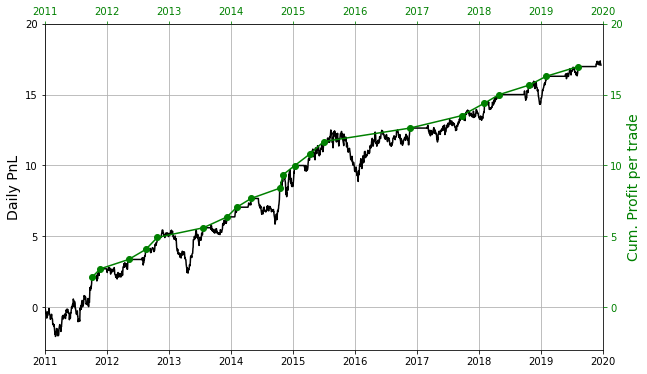

In [101]:
# TODO: major portion of those drawdowns are causing because we enter a trade at exactly 0.5 away from std but it often does not return from there. 
# while its getting further away, we lose money temporarily (unrealised PnL)
# to overcome this, enter strategy might be sth like: if we go above 0.5std of spread: wait for it to drop back down for 2-3 timeframes (optimise for best result)
#  and then enter, vice versa for dropping below -0.5 std

# Plotting them on the same chart
plot_2figs(cum_daily_pnl, cum_p_per_trade, 'Daily PnL', 'Cum. Profit per trade')

__Sharpe ratio__

In [102]:
# Portfolio size ($): 
portfolio_size = ewc[0] + beta[0]*ewa[0]
print(portfolio_size)

# Daily return
daily_ret = daily_pnl/portfolio_size
print(daily_ret)
print(np.sum(daily_ret))

39.01298599062825
Date
2010-12-31         NaN
2011-01-03   -0.002858
2011-01-04   -0.003001
2011-01-05   -0.003706
2011-01-06   -0.000631
                ...   
2019-12-16    0.003692
2019-12-17   -0.005744
2019-12-18    0.000473
2019-12-19   -0.001191
2019-12-20   -0.001249
Name: Adj Close, Length: 2259, dtype: float64
0.43762567278378706


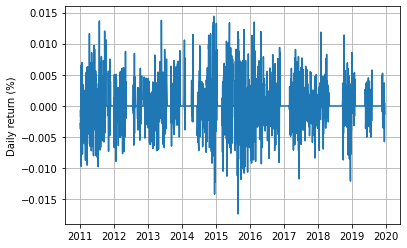

In [103]:
plt.plot(daily_ret)
plt.ylabel('Daily return (%)')
plt.grid()
plt.show()

In [104]:
np.mean(daily_pnl)

0.00756115333988182

In [105]:
# Annualised Sharpe ratio
sharpe = np.mean(daily_ret)/np.std(daily_ret)*np.sqrt(252)
sharpe
# if we use hourly: np.sqrt(252*8 trading hours) should be done

0.9036116373697278

## 6.7 Strategy analysis (2)
__Sortino ratio__

_The Sortino ratio is similar to the Sharpe ratio but it only regards the standard deviation of the negative returns. This avoids being penalised for excessive positive returns as it is the case for the Sharpe ratio and it may in some cases be a better metric._

In [106]:
Sortino = np.mean(daily_ret)/np.std(daily_ret[daily_ret<0])*np.sqrt(252)
Sortino

1.2392451984565545

__Drawdown__

$$d = \frac{cumRet}{runningMax} - 1$$

In [107]:
# running _max is the scenario where we never enter any trade that we'd lose
# cum_ret is the real scenario of our cumilative return
# d (drawdown) shows how much we lost each bad trade by entering (taking a losing risk) (aka downside volatility)
# drawdown != loss

In [108]:
def drawdown(ret):
    cum_ret = np.cumprod(ret+1)
    running_max = np.fmax.accumulate(cum_ret)    
    # Ensure the value never drops below 1
    running_max[running_max<1] = 1
    
    d = cum_ret/running_max - 1    
    return d

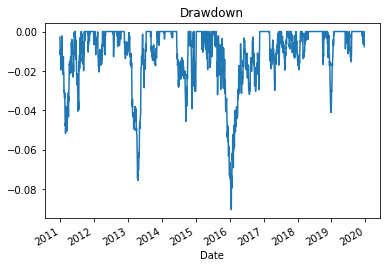

In [109]:
drawdown(daily_ret).plot()
plt.title('Drawdown')
plt.show()

# there are drawdowns over 8%. which is not good for psychology.

__Value at Risk (VaR)__

VaR measures how much the investor might lose in a single day (or month, or year), in a worst case scenario, given a specified confidence interval, usually 95% or 99%.

In [110]:
from scipy.stats import norm

In [111]:
def VaR(P, c, lkbk, rets):
    # c: confidence interval
    # P: portfolio value
    # lkbk: lookback window
    mu = np.mean(rets[-lkbk:])
    sigma = np.std(rets[-lkbk:])
    alpha = norm.ppf(1-c, mu, sigma)
    return round(P - P*(alpha + 1))    

In [112]:
c = 0.95
P = 1e6

In [113]:
print('With {:.0%} confidence, we expect that our worst daily loss will not exceed ${:,.0f} on our ${:,.2f} portfolio.'.
      format(c, VaR(P, c, 200, daily_ret),P))

With 95% confidence, we expect that our worst daily loss will not exceed $2,642 on our $1,000,000.00 portfolio.


__Histogram of Holding times__

This will give us and idea on how patient we have to be with our strategy.

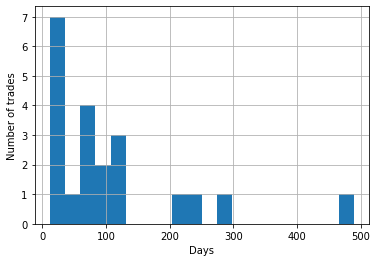

In [114]:
plt.hist(time_in_trade, bins=20)
plt.xlabel('Days')
plt.ylabel('Number of trades')
plt.grid()
plt.show()

# there is a trade where we hold for 1.5 year... so bad

__Beta__

In [115]:
# Download the data for S&P500
benchmark = yf.download('SPY', start='2011-01-01', end='2019-12-23')['Adj Close']
# Benchmark returns
benchmark_r = benchmark.pct_change()

# Correlation between strategy return and benchmark return
daily_ret.corr(benchmark_r)

# -0.04 shows that we are mostly market meutral. meaning big changes in the market won't affect us significantly

[*********************100%***********************]  1 of 1 completed


-0.04872825685972315

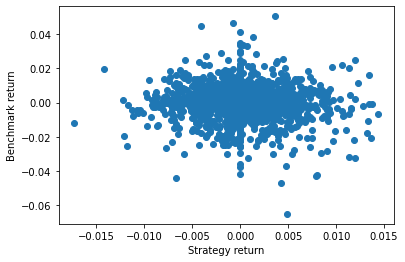

In [116]:
plt.scatter(daily_ret, benchmark_r)
plt.xlabel('Strategy return')
plt.ylabel('Benchmark return')
plt.show()